# **Phase 4 Project: Car Price Prediction**
# Technical Modeling Notebook

Authored by Mikaela Connell


---



---
This notebook and the analysis notebook both work with the car price tabular dataset found on this [Kaggle page](https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data/data).


# **Table of Contents**



*   Executive Summary
*   Dataset Overview
*   Basic Imports
*  Classical ML Approach
    * Preprocessing Functions and Testing
*   Artifical Neural Network Approach
*   References



# **Executive Summary**


---
From the analysis notebook, the results found were as follows:


**Predictive Modeling Performance**

Three machine learning models were tested to predict vehicle selling prices:

* **Linear Regression**: R² = 0.9679, MAE = $1,082

* **Random Forest**: R² = 0.9706, MAE = $1,056

* **XGBoost**: R² = 0.9670, MAE = $1,037

Random Forest and XGBoost performed slightly better than Linear Regression, reducing prediction errors. However, XGBoost had marginally higher interpretability and efficiency in handling complex relationships.

I also used an **Artificial Neural Network (ANN)** to predict car selling prices. This was achieved through the following steps:
1. Data Preprocessing
    * Transformed all categorical features into numerical features
    * Scaled numerical features to improve model stability
    * Split the dataset into training and testing sets  
2. ANN Architecture
    * Input layer: takes in all selected features
    * Hidden layers: multiple dense layers with ReLU activation to capture complex relationships
    * Output layer: a single neuron for predicting selling price using a linear activation function
3. Model Training & Evaluation
    * Used Mean Square Error (MAE) as the loss function
    * Trained the model over 50 epochs, monitoring both training loss and validation loss
    * The initial results showed overfitting, which was addressed with regularization techniques such as dropout and L2 regularization
    * Future improvements to optimize the model may be tuning hyperparameters and implementing early stopping to prevent overfitting

* MAE = $2,606


**Conclusion & Business Impact**


This analysis provides actionable insights for dealerships and individual sellers to price vehicles more effectively. By understanding key factors influencing price, sellers can make data-driven decisions to optimize profitability. Future work can explore time-series forecasting and expand feature engineering for improved accuracy.




# **Dataset Overview**


---
The following description of the dataset was taken from the Kaggle page:

**Dataset Description**:
The "Vehicle Sales and Market Trends Dataset" provides a comprehensive collection of information pertaining to the sales transactions of various vehicles. This dataset encompasses details such as the year, make, model, trim, body type, transmission type, VIN (Vehicle Identification Number), state of registration, condition rating, odometer reading, exterior and interior colors, seller information, Manheim Market Report (MMR) values, selling prices, and sale dates.

**Key Features**:
Vehicle Details: Includes specific information about each vehicle, such as its make, model, trim, and manufacturing year.

**Transaction Information**: Provides insights into the sales transactions, including selling prices and sale dates.

**Market Trends**: MMR values offer an estimate of the market value of each vehicle, allowing for analysis of market trends and fluctuations.

**Condition and Mileage**: Contains data on the condition of the vehicles as well as their odometer readings, enabling analysis of how these factors influence selling prices.





# **Basic Imports**

In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from glob import glob

# Plotting Tools
import colorcet as cc
from matplotlib.ticker import FuncFormatter

# Classical ML Models and Tools
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Neural Network Models and Tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
# Read csv file
df = pd.read_csv('car_prices.csv')

# **Classical ML Approach**


# **Data Preprocessing & Exploration**
1. Handle missing values: check for null values and impute or drop them as needed.
2. Feature engineering:
  * convert categorical variables (e.g., make, model) using one-hote encoding or label encoding
  * extract date-related features
  * create new features (e.g., age of vehicle, mileage per year)

3. Outlier detection: use box plots, z-score, and IQR to detect extreme values.
4. Feature Scaling: normalize numerical features using MinMaxScaler and StandardScaler.

# Handling Missing Values:

In [3]:
# Identify missing values
df.isnull().sum()

,0
year,0
make,8102
model,8173
trim,8431
body,10975
transmission,51325
vin,0
state,0
condition,11801
odometer,90


In [3]:
# Fill missing values from odometer and sellingprice with respective median values
df['odometer'].fillna(df['odometer'].median(), inplace=True)
df['sellingprice'].fillna(df['sellingprice'].median(), inplace=True)

<ipython-input-3-15dc872b3870>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['odometer'].fillna(df['odometer'].median(), inplace=True)
<ipython-input-3-15dc872b3870>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [4]:
# Condition values above 5 filled with the median
df.loc[df['condition'] > 5, 'condition'] = df['condition'].median()

In [5]:
# Drop null values
df.dropna(inplace=True)

In [6]:
# Drop unnecessary columns (vin and seller)
df.drop(columns=['vin', 'seller'], inplace=True)

# Feature Engineering:

In [7]:
# Ensure saledate is in datetime format
df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce', utc=True)

<ipython-input-7-b17fec046a25>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce', utc=True)


In [8]:
# Extract year and month from saledate
df['year_sold'] = df['saledate'].dt.year
df['month_sold'] = df['saledate'].dt.month

In [9]:
# Drop the original saledate column
df.drop(columns=['saledate'], inplace=True)

In [10]:
# Label encoding for high-cardinality categorical features (make, mode, and trim)
# Convert categorical labels into numerical values

label_encoder = LabelEncoder()
df['make'] = label_encoder.fit_transform(df['make'].astype(str))
df['model'] = label_encoder.fit_transform(df['model'].astype(str))
df['trim'] = label_encoder.fit_transform(df['trim'].astype(str))

In [11]:
# Frequency encode low-cardinality categorical features (body, transmission, color, interior)
# Replaces each category with its frequency in the datset

low_cardinality_cols = ['body', 'transmission', 'color', 'interior']
for col in low_cardinality_cols:
    freq = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].map(freq)

In [12]:
# Standardize numerical features (odometer, condition, year_sold, month_sold)
# Standard scaler transforms data using z-score normalization to ensure all numerical values have 0 mean and unit variance

scaler = StandardScaler()
df[['odometer', 'condition', 'year_sold', 'month_sold']] = scaler.fit_transform(df[['odometer', 'condition', 'year_sold', 'month_sold']])

df.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,year_sold,month_sold
0,2015,24,637,818,0.212448,0.965354,ca,-2.472678,-0.963873,0.188925,0.444316,20500.0,21500.0,-3.440629,2.755082
1,2015,24,637,818,0.212448,0.965354,ca,-2.472678,-1.103384,0.188925,0.106854,20800.0,21500.0,-3.440629,2.755082
2,2014,3,8,253,0.369767,0.965354,ca,0.376504,-1.258606,0.149558,0.444316,31900.0,30000.0,0.290644,-0.861268
3,2015,51,575,1212,0.369767,0.965354,ca,0.376504,-1.009254,0.188925,0.444316,27500.0,27750.0,0.290644,-0.861268
4,2014,3,33,335,0.369767,0.965354,ca,0.376504,-1.233384,0.149558,0.444316,66000.0,67000.0,-3.440629,2.755082


# **Machine Learning Models**
1. Linear model:
    * **Multiple Linear Regression**: if car price has a linear relationship with the input features

2. Tree-Based Models (for non-linear relationships)
    * **Random forest regressor**: handles categorical and numerical data well and captures complex interactions
    * **Gradient boosting (XGBoost)**: More powerful than random forest for structured data, reducing bias and variance


Steps:
1. Prepare data:
    * separate features (X) and target variable (y= sellingprice)
    * split the dataset into training (80%) and testing (20%) sets
2. Train ML models:
    * Evaluate the models using Mean Absolute Error (MAE) and R^2 score.


# Random Forest & Linear Regression Models:

In [37]:
# Define features (X) and target variable (y)
X = df.drop(columns=['sellingprice', 'state'])  # Dropping non-useful columns
y = df['sellingprice']

In [38]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

In [16]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "R² Score": r2}

# Display results
print(results)

{'Linear Regression': {'MAE': 1082.0684469470693, 'R² Score': 0.9678995197063883}, 'Random Forest': {'MAE': 1056.1185645178364, 'R² Score': 0.9706287335924727}}


In [39]:
# Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [40]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

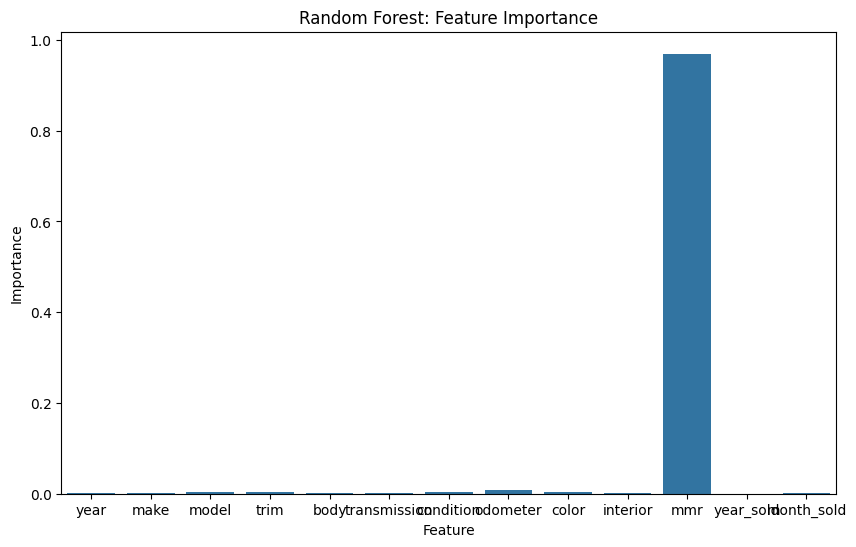

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Fit a random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Feature importance
importances = rf_model.feature_importances_

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=X_train.columns, y=importances)
plt.title('Random Forest: Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# Results of Linear Regression and Random Forest Models:

- Both models perform exceptionally well, with low error and high explanatory power
- Random Forest slightly performs Linear Regression, indicating that non-linear interactions exist in the data

1. **Linear Regression**:
    - MAE (Mean Absolute Error): ~$1,082
    - R² Score: 0.968 (~97% of variance explained)
    - Explanation: The model predicts vehicle prices with an average error of $1,082, which is relatively low. With an R² Score of 0.968, the model explains 96.8% of the variance in selling prices, meaning it fits the data well. However, since Linear Regression assumes a linear relationship between features and price, it might not fully capture complex interactions.

2. **Random Forest**:
    - MAE: ~$1,056 (slightly lower than linear regression)
    - R² Score: 0.971 (~97.1% of variance explained)
    - Explanation: Random Forest performs slightly better than Linear Regression, reducing the average error to $1,056. The higher R² Score (0.971) indicates that the model captures more complex relationships in the date. As an ensemble method, Random Forest is better at handling non-linear relationships and feature interactions, making it a stronger choice.

Next Step: try running XGBoost since it often performs even better by handling non-linearity and complex feature relationships more efficiently.

# Gradient Boosting Models (Xgboost):

In [21]:
# Define features (X) and target variable (y)
X = df.drop(columns=['sellingprice', 'state'])  # Dropping non-useful columns
y = df['sellingprice']

In [22]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Initialize and train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [24]:
# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

In [25]:
# Evaluate XGBoost model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [26]:
# Display results
print(f"XGBoost - MAE: {mae_xgb}, R² Score: {r2_xgb}")

XGBoost - MAE: 1037.184480546262, R² Score: 0.9670794525410961


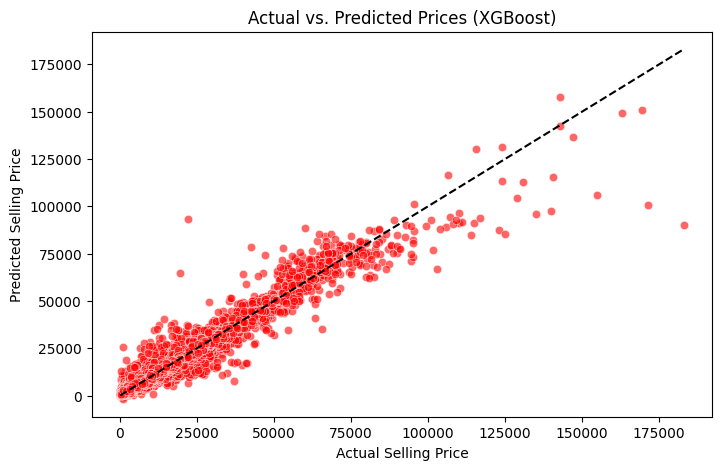

In [27]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6, color="red")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs. Predicted Prices (XGBoost)")
plt.show()

<ipython-input-32-2aaf4b625e9d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_features, y=sorted_importances, palette="Reds_r")  # Reds_r gives a dark-to-light red gradient


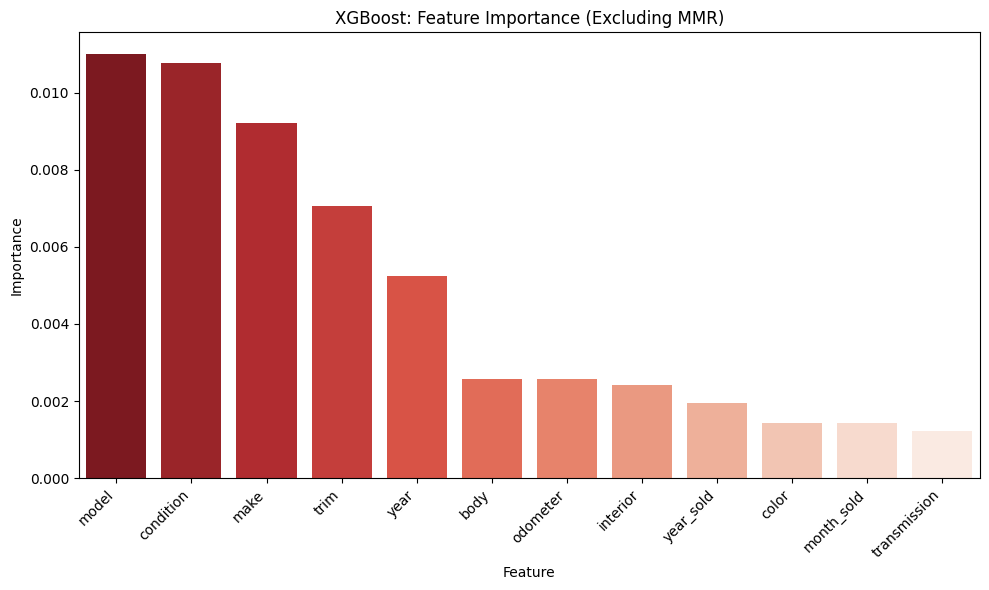

In [32]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Feature importance
importances = xgb_model.feature_importances_

# Exclude 'MMR' feature
features = [feature for feature in X_train.columns if feature != 'mmr']
importances_no_mmr = [importance for i, importance in enumerate(importances) if X_train.columns[i] != 'mmr']

# Sort features and importances in descending order
sorted_indices = sorted(range(len(importances_no_mmr)), key=lambda i: importances_no_mmr[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances_no_mmr[i] for i in sorted_indices]

# Plot the sorted feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_features, y=sorted_importances, palette="Reds_r")  # Reds_r gives a dark-to-light red gradient
plt.title('XGBoost: Feature Importance (Excluding MMR)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Results of XGBoost Model:

**MAE (Mean Absolute Error): $1,037**

* This means that, on average, the model's predicted selling price is off by about $1,037 from the actual price.

* It is slightly better than Random Forest (MAE: $1,056) and Linear Regression (MAE: $1,082), but the improvement is minimal.

**R² Score: 0.967 (~96.7% variance explained)**

* This means XGBoost explains 96.7% of the variability in vehicle prices, which is very close to Linear Regression (0.968) and Random Forest (0.971)
    
* Surprisingly, Random Forest had a slightly better R² score (0.971), which suggests that for this dataset, Random Forest captured feature relationships more effectively.



*   XGBoost has the lowest MAE, meaning its predictions are slightly more accurate.
*   However, Random Forest has the highest R² score, meaning it explains slightly more of the variation in the data.
* Overall, all three models perform well for predicting vehicle prices.



Next Steps:
- Hyperparameter tuning: adjusting learning rate, max depth for XGBoost
- Fine-tune XGBoost and Random Forest using GridSearchCV to optimize hyperparameters for better performance

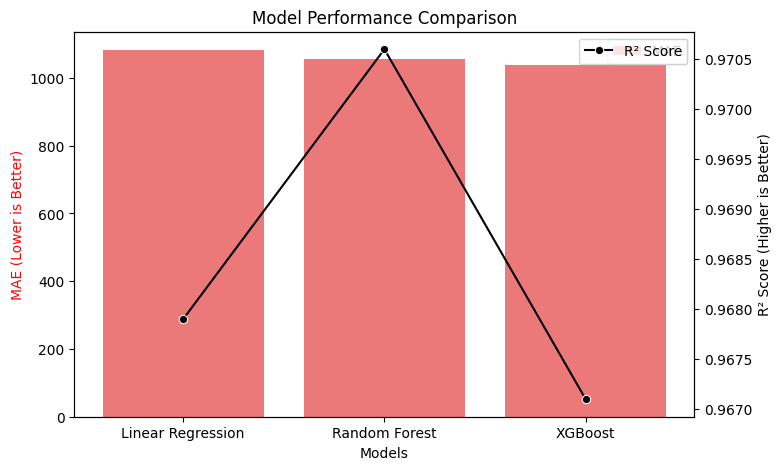

In [33]:
# Model performance metrics
models = ["Linear Regression", "Random Forest", "XGBoost"]
mae_values = [1082.07, 1056.12, 1037.18]
r2_values = [0.9679, 0.9706, 0.9671]

# Create figure
fig, ax1 = plt.subplots(figsize=(8,5))

# Plot MAE (Lower is better)
sns.barplot(x=models, y=mae_values, ax=ax1, color='red', alpha=0.6, label="MAE")

# Create a second y-axis for R² (Higher is better)
ax2 = ax1.twinx()
sns.lineplot(x=models, y=r2_values, ax=ax2, marker="o", color="black", label="R² Score")

# Labels & Titles
ax1.set_ylabel("MAE (Lower is Better)", color='red')
ax2.set_ylabel("R² Score (Higher is Better)", color='black')
ax1.set_xlabel("Models")
plt.title("Model Performance Comparison")

plt.show()


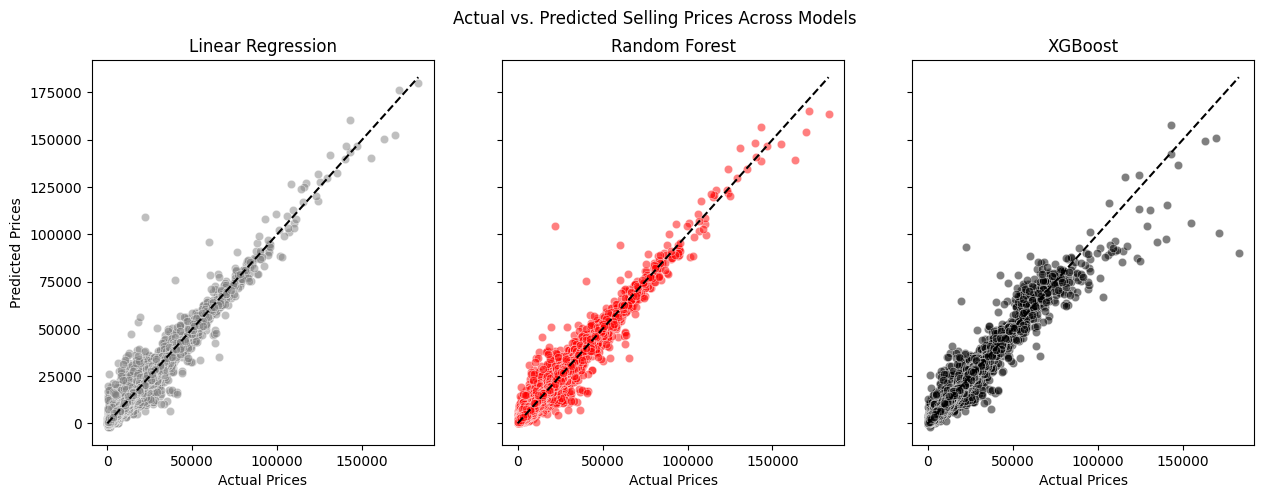

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

models = ["Linear Regression", "Random Forest", "XGBoost"]
predictions = [y_pred_lr, y_pred_rf, y_pred_xgb]  # Replace with actual model outputs
colors = ["gray", "red", "black"]

for i, ax in enumerate(axes):
    sns.scatterplot(x=y_test, y=predictions[i], ax=ax, alpha=0.5, color=colors[i])
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # 45-degree line
    ax.set_title(models[i])
    ax.set_xlabel("Actual Prices")
    if i == 0:
        ax.set_ylabel("Predicted Prices")

plt.suptitle("Actual vs. Predicted Selling Prices Across Models")
plt.show()


# **Deep Learning Model**

1. Artificial Neural Network (ANN): can capture complex interactions, but needs more data and tuning

In [17]:
# Separate target variable and features
X = df.drop(columns=['sellingprice', 'state'])
y = df['sellingprice']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for better ANN performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [21]:
# Define ANN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.2),  # Regularization to prevent overfitting
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(32, activation='relu'),  # Hidden layer
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Train the ANN
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
9545/9545 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 34562568.0000 - mae: 3169.2673 - val_loss: 3072822.2500 - val_mae: 1142.5598
Epoch 2/50
9545/9545 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 5208751.0000 - mae: 1497.8158 - val_loss: 3017162.7500 - val_mae: 1094.1282
Epoch 3/50
9545/9545 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 4979416.5000 - mae: 1480.7743 - val_loss: 3007227.2500 - val_mae: 1108.6412
Epoch 4/50
9545/9545 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 4946674.5000 - mae: 1474.0074 - val_loss: 3100517.2500 - val_mae: 1158.9889
Epoch 5/50
9545/9545 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 4817491.5000 - mae: 1460.7209 - val_loss: 3006227.2500 - val_mae: 1108.4698
Epoch 6/50
9545/9545 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 4647735.5000 - mae: 1445.6646 - val_loss: 3437540.5000 - val_mae: 1266.8628
Epoch 7/50
9545/9545 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 4276771.0000 - mae: 1388.7660 - val_loss: 3674967.2500 - val_mae: 1325.7566
Epoch 8/50
9545/9545 ━━━━━

In [23]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.2f}")

2387/2387 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 11215585.0000 - mae: 2587.7007
Test MAE: 2605.74


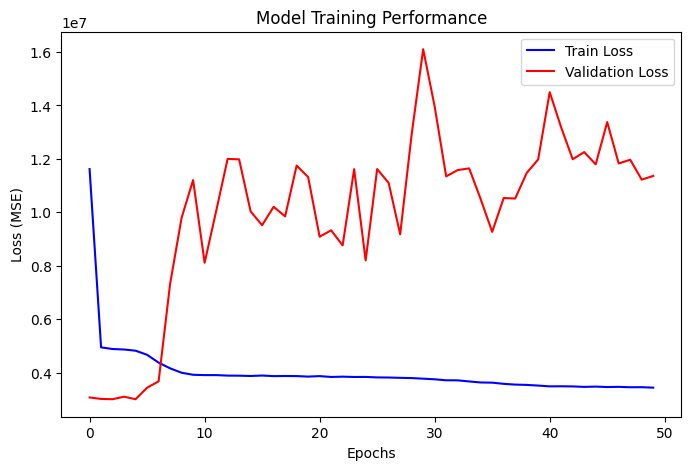

In [24]:
# Plot training loss & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Training Performance')
plt.legend()
plt.show()

2387/2387 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


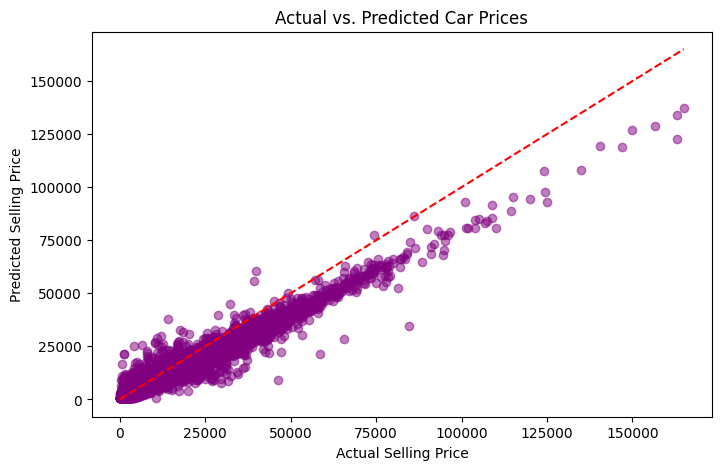

In [26]:
# Predict selling prices for test set
y_pred = model.predict(X_test)

# Compare actual vs predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs. Predicted Car Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # Reference line
plt.show()

# **Summary of Modeling Aproaches**

Random Forest and XGBoost performed slightly better than Linear Regression, reducing prediction errors. However, XGBoost had marginally higher interpretability and efficiency in handling complex relationships.

ANN model had the worst performance, with the highest mean absolute error value. This model could be improved with more fine tuning, and implementing methods such as early stopping and regularization to prevent overfitting.

This analysis provides actionable insights for dealerships and individual sellers to price vehicles more effectively. By understanding key factors influencing price, sellers can make data-driven decisions to optimize profitability. Future work can explore time-series forecasting and expand feature engineering for improved accuracy.


# **References**



*   https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data/data


